In [1]:
%matplotlib inline 
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [3]:
import os

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from scipy.stats import spearmanr

In [4]:
from access_biology_data import meta, relations, annotation, properties
from access_literature_data import medline
from access_science_shared import standardizer

import sys
sys.path.append('./../src/')
from aging_tools import inout, export, calculators
from access_aging_data import chaperome, earlier_studies, sequencing


In [5]:
import random

In [6]:
import matplotlib
matplotlib.rcParams.update({'font.size': 10})

In [7]:
out_folder = '191110_visualize_mouse_models_9_months'
in_folder = '190406_predict_fold_change_mouse'

In [8]:
save_images = True

In [9]:
from narrative import nar181026_heat_confidence_genes

In [10]:
ref_genes = standardizer.reference_genes(10090, 'orp')  # only consider supported protein coding-genes

In [11]:
all_de, detection, mice_in_comparisons, triplicate_series = nar181026_heat_confidence_genes.load_detection(
    detection_column='padj')

tissues_to_consider = ['BAT', 'Blood', 'GutEP', 'MuscSat', 'Adrenal', 'Kidney',
       'Heart', 'Liver', 'Skin', 'Stomach', 'Brain', 'SI',
       'LI', 'Cerebellum', 'WAT', 'Esophagus', 'Lung'] 
pfus=[0]

In [12]:
all_de = all_de[
    (all_de['younger'] == 4) & 
    (all_de['older'] == 9) & 
    (all_de['is_detected'] == True) &
    (all_de['de_unit'] == 'both') &
    (all_de['tissue'].isin(tissues_to_consider)) &
    (all_de['pfu'].isin(pfus)) & 
    (all_de['gene_ncbi'].isin(ref_genes))
]
all_de['significant'] = all_de['padj'] < 0.05

In [13]:
sign = all_de[['condition', 'significant']].groupby('condition').agg(sum)

In [14]:
agg = []

for condition in all_de['condition'].unique():

    p = export.get_material_path(
        '{}/predictions_{}.csv'.format(in_folder, condition))
    if os.path.exists(p):
        agg.append(pd.read_csv(p))


df = pd.concat(agg).rename(columns={'Unnamed: 0': 'condition'}).set_index('condition')
df['mean'] = df.mean(1)
d = pd.merge(sign.reset_index(), df[['mean']].reset_index())
f = d['significant'] > 0
d.loc[f, 'log_significant'] = d.loc[f, 'significant'].apply(lambda x: np.log10(x))

In [15]:
zeros = sum(~f)

In [16]:
h = []
for j in range(zeros):
    h.append(-1 + random.randrange(0, 10)/20)
d.loc[~f, 'log_significant'] = h

In [17]:
f = d['condition'].str.contains('_0_4_[0-9]*$')
d = d[f]

In [18]:
d = pd.merge(d, all_de[['condition', 'younger', 'older']].drop_duplicates())

In [19]:
agg = []

for condition in all_de['condition'].unique():

    p = export.get_material_path(
        '{}/features_{}.csv'.format(in_folder, condition))

    if os.path.exists(p):
        h = pd.read_csv(p).set_index('feature')
        h = h.mean(1).to_frame('contribution').rename_axis('feature').reset_index()
        h.loc[:, 'condition'] = condition
        agg.append(h)



u = pd.concat(agg)

In [20]:
pi = u.pivot(index='condition', columns='feature', values='contribution')

In [21]:
pi.rank(1, ascending=False).loc[:, 'rna_full_SumACGT'].mean()

4.117647058823529

In [22]:
(pi.rank(1, ascending=False).loc[:, 'rna_full_SumACGT'] == 1).sum()

8

In [23]:
is_first = pi.rank(1, ascending=False).loc[:, 'rna_full_SumACGT'] == 1
is_top_ten = pi.rank(1, ascending=False).loc[:, 'rna_full_SumACGT'].isin(range(2, 11))

In [24]:
is_not_top_ten = pi.rank(1, ascending=False).loc[:, 'rna_full_SumACGT']>10

In [25]:
is_first.sum()

8

In [26]:
is_top_ten.sum()

8

In [27]:
is_not_top_ten.sum()

1

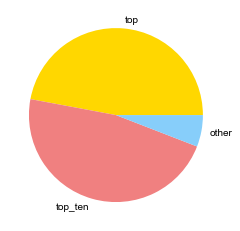

In [28]:
sizes = [is_first.sum(), is_top_ten.sum(), is_not_top_ten.sum()];
labels = ['top', 'top_ten', 'other'];
colors = ['gold', 'lightcoral', 'lightskyblue'];
 
plt.pie(sizes, labels=labels, colors=colors)


if save_images:
    export.export_image(
    '{}/pie.pdf'.format(out_folder))

In [29]:
d = d.set_index('condition')

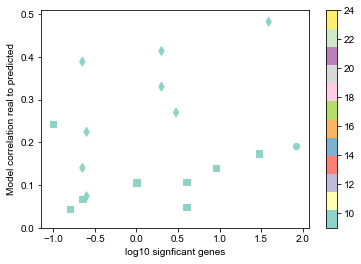

In [30]:
# plt.scatter(d.loc[~f, 'log_significant'], d.loc[~f, 'mean'], c=d.loc[~f, 'older'], s=40, cmap='viridis')

plt.scatter(
    d.loc[is_not_top_ten, 'log_significant'], 
    d.loc[is_not_top_ten, 'mean'], 
    c=d.loc[is_not_top_ten, 'older'], 
    s=40, 
    cmap='Set3',
    marker='o',
    vmin=9,
    vmax=24
)


plt.scatter(
    d.loc[is_top_ten, 'log_significant'], 
    d.loc[is_top_ten, 'mean'], 
    c=d.loc[is_top_ten, 'older'], 
    s=40, 
    cmap='Set3',
    marker='s',
    vmin=9,
    vmax=24
)

plt.scatter(
    d.loc[is_first, 'log_significant'], 
    d.loc[is_first, 'mean'], 
    c=d.loc[is_first, 'older'], 
    s=40, 
    cmap='Set3',
    marker='d',
    vmin=9,
    vmax=24
)

plt.xlabel('log10 signficant genes')
plt.ylabel('Model correlation real to predicted')
plt.colorbar()

plt.gca().set_ylim(bottom=0)

if save_images:
    export.export_image(
    '{}/prediction_accuracy.pdf'.format(out_folder))

In [31]:
is_first =  (pi.rank(1, ascending=False).loc[:, 'rna_full_SumACGT'] == 1) | \
            (pi.rank(1, ascending=False).loc[:, 'rna_cds_SumACGT'] == 1) | \
            (pi.rank(1, ascending=False).loc[:, 'gene_SumACGT'] == 1)

In [32]:
pi.shape

(17, 2236)

In [33]:
h = pd.merge(
    d.reset_index(), 
    pi.rank(
        1, ascending=False).loc[
        :, ['rna_full_SumACGT', 'rna_cds_SumACGT', 'gene_SumACGT']].min(
        1).to_frame('length_rank').rename_axis('condition').reset_index()
    

)

h = h[h['older']==9]

bins_of_interest = {
    '1-5': [1, 2, 3, 4, 5],
    '6-10': [6, 7, 8, 9, 10]
}

h.loc[:, 'bin'] =np.nan

for k in bins_of_interest.keys():
    f = h['length_rank'].isin(bins_of_interest[k])
    h.loc[f, 'bin'] = k

f = h['length_rank'] > 10
h.loc[f, 'bin'] = '11-{}'.format(int(pi.shape[1]))

g = h[['bin', 'mean']].groupby('bin')

to_visualize = pd.merge(   
    g.median().reset_index(),
    g.size().to_frame('comparisons').rename_axis('bin').reset_index()
).set_index('bin')

intended_order = [
    '1-5',
    '6-10',
    '11-{}'.format(int(pi.shape[1]))
]

to_visualize = to_visualize.loc[intended_order, :].reset_index()

/Users/tstoeger/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [34]:
to_visualize

,bin,mean,comparisons
0,1-5,0.157296,16.0
1,6-10,NaN,NaN
2,11-2236,0.190876,1.0


In [35]:
save_late_images = False

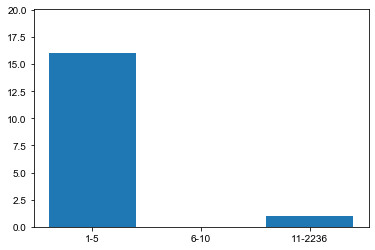

In [36]:
height = to_visualize.loc[:, 'comparisons']
bars = to_visualize.loc[:, 'bin']
y_pos = np.arange(len(bars))
 
# Create bars
plt.bar(y_pos, height)
 
# Create names on the x-axis
plt.xticks(y_pos, bars)



height = to_visualize.loc[:, 'mean']

plt.plot(y_pos, height*100, 'r')

save_late_images = True

if save_late_images:
    export.export_image(
    '{}/fraction_of_experiments.pdf'.format(out_folder))

In [37]:
h

,condition,significant,mean,log_significant,younger,older,length_rank,bin
0,Adrenal_0_4_9,30.0,0.174306,1.477121,4.0,9.0,3.0,1-5
1,BAT_0_4_9,4.0,0.107567,0.602060,4.0,9.0,4.0,1-5
2,Blood_0_4_9,0.0,0.068164,-0.650000,4.0,9.0,2.0,1-5
3,Brain_0_4_9,0.0,0.073859,-0.600000,4.0,9.0,1.0,1-5
4,Cerebellum_0_4_9,2.0,0.413945,0.301030,4.0,9.0,1.0,1-5
5,Esophagus_0_4_9,0.0,0.243449,-1.000000,4.0,9.0,3.0,1-5
6,GutEP_0_4_9,4.0,0.048424,0.602060,4.0,9.0,2.0,1-5
7,Heart_0_4_9,2.0,0.330360,0.301030,4.0,9.0,1.0,1-5
8,Kidney_0_4_9,39.0,0.482377,1.591065,4.0,9.0,1.0,1-5
9,LI_0_4_9,9.0,0.139771,0.954243,4.0,9.0,2.0,1-5


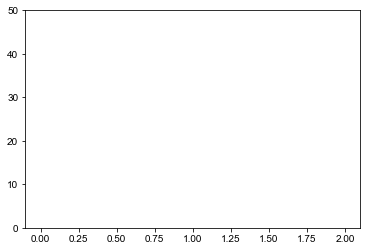

In [38]:

plt.plot(y_pos, height*100, 'r')

plt.ylim(0, 50)
# plt.gca().set_ylim(bottom=0)

if save_images:
    export.export_image(
    '{}/red_line_for_helper_axis.pdf'.format(out_folder))



In [39]:
to_visualize.sort_values('bin')

,bin,mean,comparisons
0,1-5,0.157296,16.0
2,11-2236,0.190876,1.0
1,6-10,NaN,NaN


In [40]:
d

,significant,mean,log_significant,younger,older
condition,,,,,
Adrenal_0_4_9,30.0,0.174306,1.477121,4.0,9.0
BAT_0_4_9,4.0,0.107567,0.602060,4.0,9.0
Blood_0_4_9,0.0,0.068164,-0.650000,4.0,9.0
Brain_0_4_9,0.0,0.073859,-0.600000,4.0,9.0
Cerebellum_0_4_9,2.0,0.413945,0.301030,4.0,9.0
Esophagus_0_4_9,0.0,0.243449,-1.000000,4.0,9.0
GutEP_0_4_9,4.0,0.048424,0.602060,4.0,9.0
Heart_0_4_9,2.0,0.330360,0.301030,4.0,9.0
Kidney_0_4_9,39.0,0.482377,1.591065,4.0,9.0


In [41]:
is_first

condition
Adrenal_0_4_9       False
BAT_0_4_9           False
Blood_0_4_9         False
Brain_0_4_9          True
Cerebellum_0_4_9     True
Esophagus_0_4_9     False
GutEP_0_4_9         False
Heart_0_4_9          True
Kidney_0_4_9         True
LI_0_4_9            False
Liver_0_4_9          True
Lung_0_4_9           True
MuscSat_0_4_9        True
SI_0_4_9             True
Skin_0_4_9           True
Stomach_0_4_9        True
WAT_0_4_9           False
dtype: bool

In [42]:
d.loc[is_first, 'perf'] = 'top'
d.loc[is_top_ten, 'perf'] = 'top ten'
d.loc[is_not_top_ten, 'perf'] = 'not top ten'

In [43]:
d.loc[is_first, 'perf'] = 'top'
d.loc[~is_first, 'perf'] = 'other'
# d.loc[is_top_ten, 'perf'] = 'top ten'
# d.loc[is_not_top_ten, 'perf'] = 'not top ten'

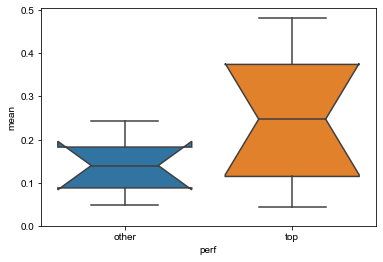

In [44]:
g = sns.boxplot(
    x='perf', 
    y='mean', 
    data=d, 
    notch=True,
    order=['other', 'top']
)

g.set(ylim=(0, None))


if save_images:
    export.export_image(
    '{}/boxplot_two.pdf'.format(out_folder))

In [45]:
from scipy.stats import mannwhitneyu

In [46]:
mannwhitneyu(
    d[d['perf']=='other']['mean'],
    d[d['perf']=='top']['mean'],
    alternative='two-sided'
)

MannwhitneyuResult(statistic=21.0, pvalue=0.18768277253339638)

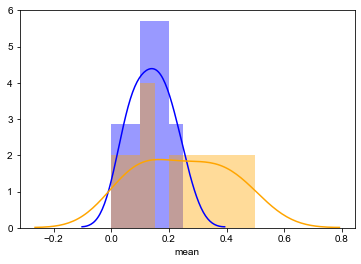

In [47]:
v = np.arange(0, 0.7, 0.05)

sns.distplot(
    d.loc[~is_first, 'mean'],
    bins=v,
    color='blue'

)

sns.distplot(
    d.loc[is_first, 'mean'],
    bins=v,
    color='orange'
)

d.loc[~is_first, 'perf'] = 'other'
d.loc[is_first, 'perf'] = 'top'

if save_images:
    export.export_image(
    '{}/histogram_two.pdf'.format(out_folder))

In [48]:
d['perf'].value_counts()

top      10
other     7
Name: perf, dtype: int64

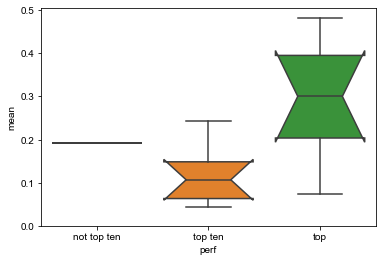

In [49]:
d.loc[is_first, 'perf'] = 'top'
d.loc[is_top_ten, 'perf'] = 'top ten'
d.loc[is_not_top_ten, 'perf'] = 'not top ten'

g = sns.boxplot(
    x='perf', 
    y='mean', 
    data=d, 
    notch=True,
    order=[
        'not top ten',
        'top ten',
        'top'
    ]
)


g.set(ylim=(0, None))

if save_images:
    export.export_image(
    '{}/boxplot_three.pdf'.format(out_folder))

/Users/tstoeger/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/tstoeger/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


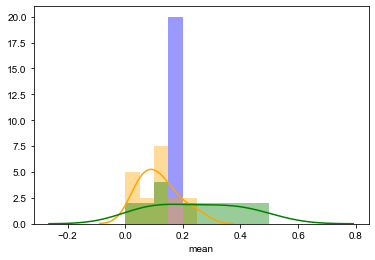

In [50]:
v = np.arange(0, 0.7, 0.05)

sns.distplot(
    d.loc[is_not_top_ten, 'mean'],
    bins=v,
    color='blue'

)

sns.distplot(
    d.loc[is_top_ten, 'mean'],
    bins=v,
    color='orange'
)


sns.distplot(
    d.loc[is_first, 'mean'],
    bins=v,
    color='green'
)

d.loc[~is_first, 'perf'] = 'other'
d.loc[is_first, 'perf'] = 'top'

if save_images:
    export.export_image(
    '{}/histogram_three.pdf'.format(out_folder))

In [51]:
is_first =  (pi.rank(1, ascending=False).loc[:, 'rna_full_SumACGT'] == 1) | \
            (pi.rank(1, ascending=False).loc[:, 'rna_cds_SumACGT'] == 1) | \
            (pi.rank(1, ascending=False).loc[:, 'gene_SumACGT'] == 1)


In [52]:
d.loc[is_first, 'perf'] = 'top'
d.loc[~is_first, 'perf'] = 'other'

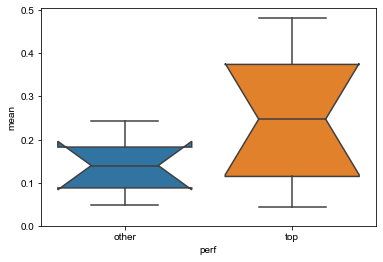

In [53]:
g = sns.boxplot(
    x='perf', 
    y='mean', 
    data=d, 
    notch=True,
    order=['other', 'top']
)

g.set(ylim=(0, None))


if save_images:
    export.export_image(
    '{}/boxplot_two_all_length.pdf'.format(out_folder))

In [54]:
d['perf'].value_counts()

top      10
other     7
Name: perf, dtype: int64

In [55]:
mannwhitneyu(
    d[d['perf']=='other']['mean'],
    d[d['perf']=='top']['mean'],
    alternative='two-sided'
)

MannwhitneyuResult(statistic=21.0, pvalue=0.18768277253339638)

In [56]:
d.head()

,significant,mean,log_significant,younger,older,perf
condition,,,,,,
Adrenal_0_4_9,30.0,0.174306,1.477121,4.0,9.0,other
BAT_0_4_9,4.0,0.107567,0.602060,4.0,9.0,other
Blood_0_4_9,0.0,0.068164,-0.650000,4.0,9.0,other
Brain_0_4_9,0.0,0.073859,-0.600000,4.0,9.0,top
Cerebellum_0_4_9,2.0,0.413945,0.301030,4.0,9.0,top


In [57]:
helper = pd.merge(
    d.reset_index()[['condition', 'mean']],
    all_de[['condition', 'tissue', 'older']].drop_duplicates()
).pivot(index='tissue', columns='older', values='mean')

In [58]:
def nice_plot(h):
    t = h.copy()
    
    tissue_dict = {
        'Adrenal': 'Adrenal gland',
        'BAT': 'Brown adipose tissue',
        'Blood': 'Blood',
        'Brain': 'Frontal cortex',
        'Cerebellum': 'Cerebellum',
        'Esophagus': 'Esophagus',
        'GutEP': 'Gut epithelium',
        'Heart': 'Heart',
        'Kidney': 'Kidney',
        'LI': 'Large intestine',
        'Liver': 'Liver',
        'Lung': 'Lung',
        'MuscSat': 'Muscle',
        'SI': 'Small intestine',
        'Skin': 'Skin',
        'Stomach': 'Stomach',
        'WAT': 'White adipose tissue'
    }
    
    t = t.rename(index=tissue_dict)
    t = t.sort_index()
    
    plt.figure(figsize=(4, 5))


    sns.heatmap(
        t, 
        cmap='YlOrBr', 
        annot=True)

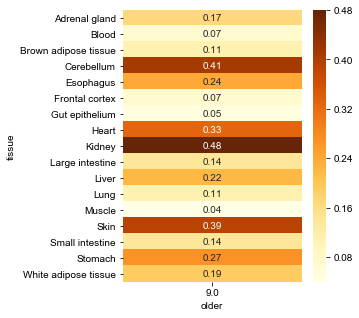

In [59]:
nice_plot(helper.apply(lambda x: np.round(x, 2)))


if save_images:
    export.export_image(
    '{}/table_nice.pdf'.format(out_folder))

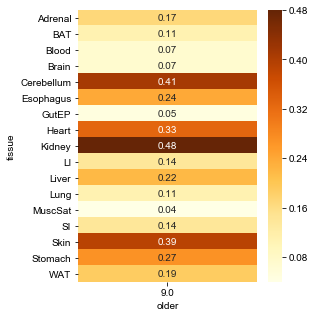

In [60]:
plt.figure(figsize=(4, 5))



sns.heatmap(
    helper.apply(lambda x: np.round(x, 2)),
    cmap='YlOrBr', 
    annot=True)


if save_images:
    export.export_image(
    '{}/table.pdf'.format(out_folder))

In [61]:
d['older'].value_counts()

9.0    17
Name: older, dtype: int64

In [62]:
spearmanr(d.loc[:, 'significant'], d.loc[:, 'mean'])

SpearmanrResult(correlation=0.20852789817887454, pvalue=0.42186994810863043)

In [63]:
if save_images:
    export.export_full_frame(
        '{}/mean_prediction.xlsx'.format(out_folder),
    d.drop('log_significant', 1),
    )

In [64]:
d[d['significant']==0].sort_values('mean', ascending=False)

,significant,mean,log_significant,younger,older,perf
condition,,,,,,
Skin_0_4_9,0.0,0.388931,-0.65,4.0,9.0,top
Esophagus_0_4_9,0.0,0.243449,-1.00,4.0,9.0,other
Liver_0_4_9,0.0,0.224692,-0.60,4.0,9.0,top
SI_0_4_9,0.0,0.140286,-0.65,4.0,9.0,top
Brain_0_4_9,0.0,0.073859,-0.60,4.0,9.0,top
Blood_0_4_9,0.0,0.068164,-0.65,4.0,9.0,other
MuscSat_0_4_9,0.0,0.044353,-0.80,4.0,9.0,top


In [65]:
d.sort_values('mean', ascending=False)

,significant,mean,log_significant,younger,older,perf
condition,,,,,,
Kidney_0_4_9,39.0,0.482377,1.591065,4.0,9.0,top
Cerebellum_0_4_9,2.0,0.413945,0.301030,4.0,9.0,top
Skin_0_4_9,0.0,0.388931,-0.650000,4.0,9.0,top
Heart_0_4_9,2.0,0.330360,0.301030,4.0,9.0,top
Stomach_0_4_9,3.0,0.269998,0.477121,4.0,9.0,top
Esophagus_0_4_9,0.0,0.243449,-1.000000,4.0,9.0,other
Liver_0_4_9,0.0,0.224692,-0.600000,4.0,9.0,top
WAT_0_4_9,83.0,0.190876,1.919078,4.0,9.0,other
Adrenal_0_4_9,30.0,0.174306,1.477121,4.0,9.0,other


In [66]:
def z(x):
    return (x - np.mean(x)) / np.std(x)

In [67]:
piz = pi.apply(lambda x: z(x), 1)

In [68]:
piz = piz.loc[:, piz.isnull().sum() == 0]

In [69]:
collected_importance = pi.mean().to_frame('mean importance')

In [70]:
collected_importance = collected_importance.sort_values(
    'mean importance', 
    ascending=False)

In [71]:
collected_importance.loc[:, 'cumulative'] = collected_importance['mean importance'].cumsum()

In [72]:
if save_images:
    export.export_full_frame(
        '{}/collected_importance.xlsx'.format(out_folder),
    collected_importance)

In [73]:
pi.loc['WAT_0_4_9', :].sort_values(ascending=False)

feature
tf_Pparg             0.055418
tf_Rela              0.053374
tf_Brd4              0.049242
tf_different_tfs     0.044737
tf_Nkx3-1            0.043152
tf_Nr1d1             0.041404
tf_Foxa1             0.037562
tf_Elf5              0.034944
tf_Pou5f1            0.031934
gene_G               0.025115
tf_Cebpa             0.023098
tf_Tfap2a            0.021625
gene_A               0.020203
tf_Ar                0.017289
rna_full_SumACGT     0.017165
gene_SumACGT         0.016809
rna_cds_SumACGT      0.014735
gene_T               0.013684
tf_Kmt2a             0.013440
tf_Nkx2-1            0.012727
rna_full_CG          0.012339
tf_Irf3              0.011812
tf_Stat3             0.010843
tf_E2f3              0.010083
tf_Nr3c1             0.009679
tf_Cebpb             0.008458
tf_Gata6             0.007916
tf_Sox2              0.007728
tf_Myod1             0.007337
tf_Pbx1              0.006222
                       ...   
miRNA_miR-6537-5p    0.000000
miRNA_miR-6538       0.000000
mi

In [74]:
pi.shape

(17, 2236)

In [75]:
collected_importance

,mean importance,cumulative
feature,,
rna_full_SumACGT,0.118062,0.118062
tf_different_tfs,0.067300,0.185363
gene_SumACGT,0.059564,0.244927
rna_full_CG,0.050498,0.295425
rna_cds_SumACGT,0.049886,0.345311
gene_T,0.029742,0.375053
gene_A,0.029229,0.404282
gene_G,0.029140,0.433423
tf_Brd4,0.019078,0.452500


In [76]:
pi.mean().sort_values(ascending=False).cumsum()

feature
rna_full_SumACGT        0.118062
tf_different_tfs        0.185363
gene_SumACGT            0.244927
rna_full_CG             0.295425
rna_cds_SumACGT         0.345311
gene_T                  0.375053
gene_A                  0.404282
gene_G                  0.433423
tf_Brd4                 0.452500
gene_C                  0.471106
miRNA_total             0.488209
gene_CG                 0.504216
tf_Pou5f1               0.516429
tf_Pparg                0.526824
tf_Ppara                0.536625
exons_max_ensembl       0.545748
tf_Rela                 0.554169
exons_min_ensembl       0.562575
tf_Med1                 0.570505
tf_Nr3c1                0.578194
tf_Kmt2b                0.585366
tf_Esr1                 0.592270
exons_median_ensembl    0.599056
tf_Nr1d1                0.605765
tf_Runx2                0.612306
transcripts_ensembl     0.618294
chromosome              0.623946
tf_Nr1d2                0.629555
tf_Stat3                0.634785
tf_Cebpb                0.639732
  

In [77]:
x = pi.transpose().rank(ascending=False)

In [78]:
x.shape

(2236, 17)

In [79]:
x

condition,Adrenal_0_4_9,BAT_0_4_9,Blood_0_4_9,Brain_0_4_9,Cerebellum_0_4_9,Esophagus_0_4_9,GutEP_0_4_9,Heart_0_4_9,Kidney_0_4_9,LI_0_4_9,Liver_0_4_9,Lung_0_4_9,MuscSat_0_4_9,SI_0_4_9,Skin_0_4_9,Stomach_0_4_9,WAT_0_4_9
feature,,,,,,,,,,,,,,,,,
chromosome,38.0,23.0,49.0,13.0,40.0,56.0,45.0,24.0,65.0,13.0,27.0,32.0,18.0,21.0,43.0,29.0,41.0
exons_max_ensembl,86.0,20.0,15.0,12.0,21.0,31.0,10.0,33.0,14.0,20.0,18.0,26.0,26.0,8.0,18.0,14.0,62.0
exons_median_ensembl,43.0,21.0,34.0,25.0,14.0,43.0,12.0,34.0,13.0,24.0,24.0,46.0,14.0,16.0,26.0,18.0,61.0
exons_min_ensembl,20.0,30.0,28.0,24.0,10.0,52.0,20.0,17.0,32.0,12.0,17.0,36.0,12.0,23.0,88.0,23.0,71.0
gene_A,15.0,3.0,10.0,5.0,9.0,12.0,7.0,13.0,9.0,6.0,12.0,6.0,4.0,4.0,10.0,7.0,13.0
gene_C,25.0,19.0,12.0,11.0,7.0,27.0,13.0,8.0,10.0,8.0,11.0,13.0,11.0,10.0,7.0,13.0,36.0
gene_CG,8.0,22.0,11.0,21.0,11.0,29.0,15.0,11.0,18.0,9.0,20.0,8.0,7.0,14.0,9.0,11.0,32.0
gene_G,5.0,6.0,5.0,7.0,8.0,22.0,4.0,16.0,12.0,7.0,10.0,5.0,3.0,6.0,12.0,10.0,10.0
gene_SumACGT,3.0,4.0,2.0,4.0,4.0,5.0,2.0,6.0,6.0,2.0,2.0,1.0,1.0,3.0,4.0,3.0,16.0


In [80]:
if save_images:
    export.export_full_frame(
        '{}/ranks.xlsx'.format(out_folder),
    x)

In [81]:
x.median(1).sort_values()

feature
tf_different_tfs           3.0
gene_SumACGT               3.0
rna_full_SumACGT           3.0
rna_cds_SumACGT            5.0
rna_full_CG                6.0
gene_G                     7.0
gene_T                     8.0
gene_A                     9.0
gene_C                    11.0
gene_CG                   11.0
miRNA_total               16.0
exons_max_ensembl         20.0
tf_Pparg                  22.0
exons_min_ensembl         23.0
exons_median_ensembl      24.0
tf_Brd4                   25.0
tf_Rxra                   30.0
chromosome                32.0
tf_Kmt2b                  33.0
tf_Nr3c1                  34.0
tf_Esr1                   34.0
tf_Pou5f1                 36.0
tf_Ctcf                   38.0
tf_Stat3                  41.0
tf_Nr1d1                  43.0
tf_Cebpb                  44.0
transcripts_ensembl       45.0
tf_Spi1                   50.0
tf_Klf4                   52.0
tf_Rela                   52.0
                         ...  
miRNA_miR-7083-5p       1462.0


In [82]:
x.columns = [y.replace('_0_', '_') for y in x.columns]

<Figure size 1440x1440 with 0 Axes>

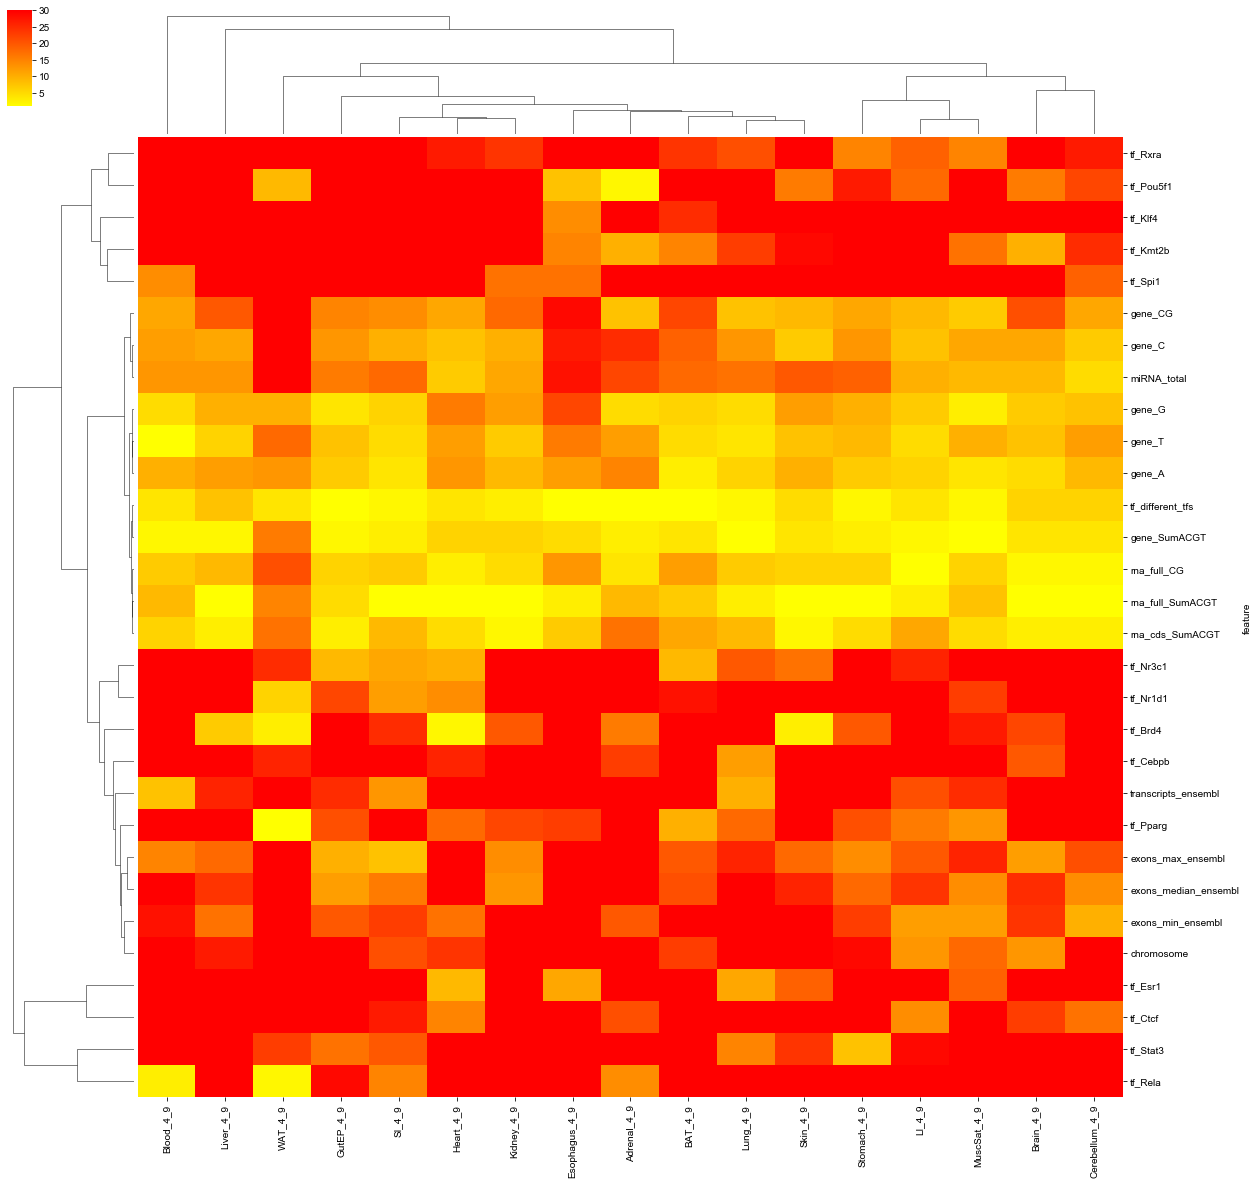

In [83]:
plt.figure(figsize=(20, 20))

sns.clustermap(
    x.loc[x.median(1).sort_values().index[:30], :], 
    vmin=1, 
    vmax=30, 
    cmap='autumn_r', 
    method='ward',
    figsize=(20, 20)
)


if save_images:
    export.export_image(
        '{}/autumn_to_30.pdf'.format(out_folder))